# Pattern-Guided Integrated Gradients

[Sundararajan et al. (2017)](https://arxiv.org/abs/1703.01365) and [Kindermans et al. (2017)](https://arxiv.org/abs/1705.05598) motivate their methods, Integrated Gradients (IG) and PatternAttribution (PA), respectively, with different stress tests for attribution methods. 

In this notebook we show that IG fails the stress test that PA passes and vice versa. 

We then introduce Pattern-Guided Integrated Gradients (PGIG), a hybrid method, and show that PGIG passes all stress tests. 

## 1) The Stress Tests: Overview

IG mitigates the *saturation problem* that occurs at function plateaus where the gradient backpropagation is stopped due to a zero gradient. PA does not pass this test, i.e. it always assigns zero scores to inputs that activated the output neurons at function plateaus. 

PA, however, does not attribute importance to noise in the input. More precisely, it does not attribute importance to inputs that are filtered by the model because they do not carry information about the target/label. IG fails this test, as we will demonstrate below. 

We argue that input neurons that activate output neurons should be attributed importance and that noise which is filtered by the model should not be salient. We propose Pattern-Guided Integrated Gradients and show that this new hybrid method achieves just that: _Like IG, it mitigates the saturation problem and like PA, it bypasses noise._

In [1]:
import numpy as np
from overrides import overrides
import matplotlib.pyplot as plt
from typing import Tuple
import copy
import warnings
from numpy import savetxt
import os 
%matplotlib inline
np.random.seed(42)

## 2) Pattern Estimation Functions

Let us first define the function we need to compute patterns, as introduced in [Kindermans et al. (2017)](https://arxiv.org/abs/1705.05598). 

The pattern is computed as 

$p_{+} = \frac{E_{+}[xy]-E_{+}[x]E[y]}{w^{T}E_{+}[xy]-w^{T}E_{+}[x]E[y]}$

where $E$ denotes the expected value and $E_{+}$ denotes the expected value in the positive regime of a ReLU activated layer. 

In [2]:
def positive_regime(input: np.array, output: np.array, feature_in: int, feature_out: int) -> Tuple[np.array, np.array]:
    """
    Filter the positive regime. 
    
    Args:
        input: Input array of shape (N, features_in).
        output: Output array of shape (N, features_out).
        feature_in: Input feature dimension to consider with 0 <= feature_in <= dim_in.
        feature_out: Output feature dimension to consider with

    Returns: Filtered input array of shape (N-M, 1) and corresponding output array of shape (N-M, 1),
    where M is the number of negative outputs.
    """

    # Collect input and output features at positions feature_in and feature_out, respectively.
    features_in = input[:, feature_in]
    features_out = output[:, feature_out]

    # Collect inputs and corresponding outputs where feature_out > 0
    x_plus = []
    y_plus = []

    for idx, feature_out in enumerate(features_out):
        if feature_out > 0:
            x_plus.append(features_in[idx])
            y_plus.append(features_out[idx])
            
    return np.array(x_plus), np.array(y_plus)


def compute_pattern(input: np.array, output: np.array, weights: np.array) -> np.array:
    """
    The pattern estimation according to Eq. 7 (Kindermans et al., 2017) for the positive regime.  

    Args:
        input: Input to the model of shape (N, features_in).
        output: ReLU activated output of the model of shape (N, features_out).
        weights: Weights of the model of shape (features_in, features_out).


    Returns: The pattern estimation (a+) of shape (features_in, features_out).

    """

    # Create three matrices E[x+ y], E[x+].
    E_x_plus_matrix = np.zeros_like(weights, dtype=np.double) 
    E_x_plus_times_y_matrix = np.zeros_like(weights, dtype=np.double)

    # Populate the matrices above.
    dims_in, dims_out = weights.shape
    for dim_in in range(dims_in):
        for dim_out in range(dims_out):
            # Collect all x,y for which ReLU(wTx) = y > 0
            x_plus, y_plus = positive_regime(input=input,
                                             output=output,
                                             feature_in=dim_in,
                                             feature_out=dim_out)

            # Create the expected values, aka means.
            E_x = np.mean(x_plus)
            E_x_y = np.mean(x_plus * y_plus)

            # Populate the matrices above.
            E_x_plus_matrix[dim_in][dim_out] = E_x 
            E_x_plus_times_y_matrix[dim_in][dim_out] = E_x_y 

    # Create a matrix holding the mean of the output
    E_y = np.mean(output)
    E_y_matrix = np.full_like(weights, E_y, dtype=np.double)

    # Compute the nominator and denominator according to Eq. 7.
    nominator = E_x_plus_times_y_matrix - (E_x_plus_matrix * E_y_matrix)
    denominator = np.matmul(weights.T, E_x_plus_times_y_matrix) - np.matmul(weights.T, (E_x_plus_matrix * E_y_matrix))
    pattern = nominator / denominator

    return pattern

## 3) Stress Test: Noisy Inputs

Let us replicate the paper experiments in Kindermans et al. (2017).

### Target
We first create the target $z$ within the bounds (-2,2). 

In [3]:
left_limit, right_limit = -2, 2  # domain lower bound
step = 0.01 # determines number of data point within domain
z = np.array([np.arange(left_limit, right_limit, step=step)])  # target

### Signal

We can now create a signal which perfectly correlates with $z$, but only in the first dimension. To this end, we use the base vector $(1, 0)^T$ for the signal.

Text(0.5, 1.0, 'Signal')

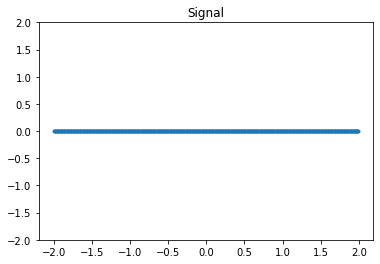

In [4]:
base_vector_signal = np.array([[1], [0]])  # signal base vector
signal = (z * base_vector_signal).T  # target scales base vector, signal and target correlate

plt.scatter(signal[:,0], signal[:,1], marker='.')
plt.ylim(-2, 2)
plt.title('Signal')

### Distractor
Next, we create a distractor that does not covary with the target. We use the base vector $(1,1)^T$ and scale it with $\epsilon \sim N(\mu, \sigma)$.

Text(0.5, 1.0, 'Distractor')

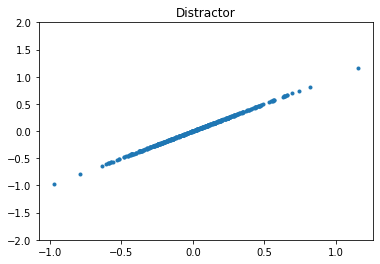

In [5]:
mu, sigma = 0, 0.3  # mean and variance of normal distribution to sample noise from
eps = np.random.normal(mu, sigma, len(signal))  # scale factors for noise base vector
base_vector_distractor = np.array([[1], [1]])  # noise base vector
distractor = (eps * base_vector_distractor).T  # noise base vector scales with samples from random distribution

plt.scatter(distractor[:, 0], distractor[:, 1], marker='.')
plt.ylim(-2, 2)
plt.title('Distractor')

Note: At first it might seem there is correlation, but the distractor above is not aligned with the target and signal. 

## Data 
The data is the signal plus the distractor. 

Text(0.5, 1.0, 'Data')

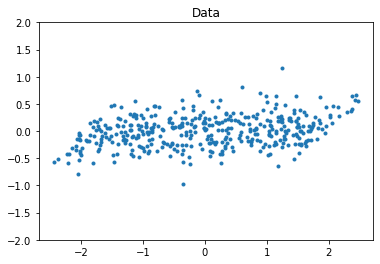

In [6]:
X = signal + distractor

plt.scatter(X[:,0], X[:,1], marker='.')
plt.ylim(-2, 2)
plt.title('Data')

## Model

The model which achieves $w^{T}x = y$ must learn a weights vector orthogonal to the base vector of the distractor and scale it with the target. We can solve this analytically, $w = (1, -1)^{T}$:

In [7]:
w = np.array([[1], [-1]])

### Pattern Estimation

Let us now estimate the pattern for this model. Hopefully the first dimension receives a value close to 1.0 and the second dimension a value close to 0.0. This would reflect that the method recognized that the model cancels the noise in the second dimension. 

In [8]:
p = compute_pattern(input=X, output=z.T, weights=w)
p

array([[1.01835493],
       [0.01835493]])

## Differential Layers

It is soon time to move beyond the simple case for which we now define some differential layers.

Below, we define 

    - a ReLU layer
    - a Linear layer w/ an optional ReLU activation and an optional unit bias
    - a PatternNet layer (inherits from Linear) and 
    - a PatternAttribution layer (inherits from Linear). 

The dense layers differ in how they propagate back incoming gradients: In case of the linear layer, the gradient wrt the inputs is simply the incoming gradient times the weights $w$. In case of PatternNet, we multiply with the pattern $p$ instead of the weights, and in case of PatternAttribution, we multiply with $w \circ p$.  

In [9]:
class ReLU:
    """Differentiable ReLU implementation."""

    def __init__(self, x=None):
        self.x = x

    @staticmethod
    def relu(x):
        """
        The ReLU function.

        Args:
            x: Input float.

        Returns: ReLU(x)
        """
        return np.maximum(0, x)

    def forward(self, x):
        """
        Applies the ReLU function.

        Args:
            x: Input.

        Returns: ReLU(x).
        """
        self.x = x
        return ReLU.relu(x)

    def backward(self, grad_in):
        """
        Propagates back the incoming gradient if the input to this function greater 0.0. Else 0.0 is propagated back.
        Args:
            grad_in: Incoming gradient.

        Returns: Gradient wrt input.
        """
        if self.x is None:
            raise ValueError('Perform a forward pass first.')
        if self.x > 0.:
            grad_out = grad_in
            return grad_out
        else:
            return 0.

class Linear:
    def __init__(self, 
                 w: np.array, 
                 has_unit_bias=False, 
                 has_relu_activation=False):
        """
        Differentiable linear layer with optional ReLu activation.

        Args:
            w: Model weights of shape (features_in, feature_out).
            has_unit_bias: Whether or not this layer has a unit bias neuron (weight 1, activation 1).
            has_relu_activation: Whether or not this layer is relu-activated. 
        """
        self.has_unit_bias = has_unit_bias
        if not self.has_unit_bias:
            self.w = w
        else: 
            self.w = np.concatenate((w, np.array([[1.0]]))) # add bias weight
            
            
        self.has_relu_activation = has_relu_activation
        if self.has_relu_activation:
             self.relu = ReLU()
        else:
            self.relu = None

    def forward(self, x):
        """
        Forward pass, y=w^Tx+b or y=ReLU(w^Tx+b) if relu is activated. b = 1 if has_unit_bias, 0 else. 

        Args:
            x: Input array.

        Returns: Linear transformation of the input.
        """
        if self.has_unit_bias:
            if x.ndim == 1: 
                _x = np.expand_dims(x, 1)
            else:
                _x = x
            self._x = np.concatenate((_x, np.array([[1.0]]))) # add bias activation
            
        else:
            self._x = x
            
        self._z = np.matmul(self.w.T, self._x)
            
        if self.has_relu_activation:
            self._y = self.relu.forward(self._z)
        else:
            self._y = self._z
        
        
        return self._y

    def backward(self, grad_in):
        """
        Backward propagation of the incoming gradient onto the input.
        Args:
            grad_in: Incoming gradient.

        Returns: Gradient wrt input.
        """
        if self.has_relu_activation:
            _grad_in = self.relu.backward(grad_in)
        else:
            _grad_in = grad_in
        grad_out = self.w * _grad_in
        
        if self.has_unit_bias:
            grad_out = grad_out[:-1] # do not return grad wrt bias
        
        return grad_out


class Pattern(Linear):
    
    def __init__(self, 
                 w, 
                 has_unit_bias, 
                 has_relu_activation, 
                 pattern = None):
        """
        Abstract class for pattern-based explainability methods.
        
        Implements the pattern computation. 
        
        Args: 
            w: Model weights of shape (features_in, features_out).
            has_unit_bias: Whether or not this layer has a unit bias neuron (weight 1, activation 1).
            has_relu_activation: Whether or not this layer is relu-activated.
            patterns: Model patterns of shape (features_in, features_out).
        """
        super().__init__(w=w,
                        has_unit_bias=has_unit_bias,
                        has_relu_activation=has_relu_activation)
        if pattern is not None:
            assert pattern.shape == self.w.shape, 'Shape mismatch between patterns and weights.'
        self.pattern = pattern
    
    @overrides
    def backward(self, grad_in):
        raise NotImplemented
        
    def set_pattern(self, X): 
        """
        Computes the pattern for this layer. 
        
        Args: 
            X: Inputs to this layer of shape (N, features_in).
        
        Returns: This layer's pattern, this layer's outputs.
        """
        assert self.pattern is None, 'For safety reasons patterns cannot be overwritten.'
        _outputs = []
        for x in X: 
            _y = self.forward(x)
            _outputs.append(_y)
        _outputs = np.array(_outputs)
        _w = w if not self.has_unit_bias else self.w[:-1] # remove bias weight
        self.pattern = compute_pattern(input=X, output=_outputs, weights=_w)
        if self.has_unit_bias:
            self.pattern = np.concatenate((self.pattern, np.array([[0.0]]))) # bias is zero, see paper 
        assert self.pattern.shape == self.w.shape
        return self.pattern, _outputs
    
class PatternNet(Pattern):

    def __init__(self, 
                 w,
                 has_unit_bias, 
                 has_relu_activation, 
                 pattern=None):
        """PatternNet, aka back propagation w/ patterns instead of weights."""
        super().__init__(w=w, 
                         has_unit_bias=has_unit_bias,
                         has_relu_activation=has_relu_activation,
                         pattern=pattern)

    @overrides
    def backward(self, grad_in):
        """
        Signal backpropagation with patterns.

        Args:
            grad_in: Incoming gradients, aka signal.

        Returns: This layer's input signal.
        """
        if self.has_relu_activation:
            grad_out = self.relu.backward(grad_in)
        else:
            grad_out = grad_in
        grad_out = grad_in * self.pattern
        if self.has_unit_bias: 
            grad_out = grad_out[:-1] # do not return grad wrt bias 
        return grad_out

class PatternAttribution(Pattern):

    def __init__(self, 
                 w,
                 has_unit_bias = False, 
                 has_relu_activation = False,
                 pattern = None):
        """
        PatternAttribution, aka backward propagation with patterns * weights instead of with original weights.
        """
        super().__init__(w=w,
                         has_unit_bias = has_unit_bias, 
                         has_relu_activation=has_relu_activation,
                         pattern=pattern)

    @overrides
    def backward(self, grad_in):
        """
        Gradient back propagation with patterns.

        Args:
            grad_in: Incoming gradient.

        Returns: Pattern attributions.
        """
        if self.has_relu_activation:
            grad_out = self.relu.backward(grad_in)
        else:
            grad_out = grad_in
        w_p = self.w * self.pattern # this is automatically a sanity check: if pattern not set, this fails
        grad_out = w_p * grad_out
        if self.has_unit_bias:
            grad_out = grad_out[:-1] # do not return bias attribution
        return grad_out


## Signal Reconstruction
With PatternNet we can now reconstruct the signal. 

Estimated pattern:
[[1.01835493]
 [0.01835493]]


Text(0.5, 1.0, 'Signal Reconstructed w/ PatternNet')

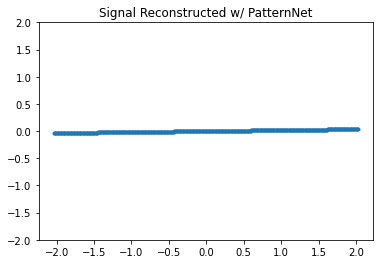

In [10]:
pattern_net = PatternNet(w=w, 
                         has_unit_bias=False,
                         has_relu_activation=False,
                         pattern=None)


_p, _ = pattern_net.set_pattern(X) # also sets the pattern in pattern_net
print('Estimated pattern:')
print(_p)

signal_reconstructed = pattern_net.backward(z)

plt.scatter(signal_reconstructed[0], signal_reconstructed[1], marker='.')
plt.ylim(-2, 2)
plt.title('Signal Reconstructed w/ PatternNet')

PatternNet sucessfully bypassed the noise in this stress test. Let us now combine the noise test with the saturation test, a stress scenario for attribution methods, discussed by [Sundararajan et al. (2017)](https://arxiv.org/abs/1703.01365) (inter alia).

## 4) Stress Test: Saturation


Saturation occurs when a function plateaus. At the plateau the gradient becomes zero which is why all input features that contributed to the model output at the plateau receive a zero-gradient. Some explainability methods, such as PatternAttribution, couple the saliency computation to the gradient which is why these methods attribute zero importance to input features that contributed to the plateaued activation, as we will see further below. This is acceptable if the model output is zero at the plateau but in all other cases, the contributing feature should not receive zero importance. 

To introduce a non-zero plateau, we use $f(x) = 1 - ReLU(1 - w^{T}x)$.  $f$ introduces a plateau after $w^{T}x>1$. 

Let us express $f$ in terms of a two layer feed forward network. 

Let $f_{1}$ be a ReLU activated dense layer with a unit bias and with $-w = (-1, 1)^{T}$ as its weights ($w$ as defined above) and let $f_{2}$ be another dense layer with $(-1)$ as its weight, again with a unit bias. Then, $f(x) = f_{2}(f_{1}(x)) = -ReLU(-w^{T}x + 1) + 1$. 


In [11]:
class Sequential: 
    
    def __init__(self, layers):
        """
        Sequential model interface. 
        
        Args:
            layers: The layers in the order they should process the input. 
        """
        self.layers = layers
        
    
    def forward(self, x): 
        for layer in self.layers:
            x = layer.forward(x)
        return x 
    
    def backward(self, grad_in):
        grad_out = grad_in
        for layer in reversed(self.layers):
            grad_out = layer.backward(grad_out)
        return grad_out
        
    def set_patterns(self, X):
        outputs = X
        patterns = []
        for layer in self.layers:
            assert isinstance(layer, Pattern), 'Layer must be a Pattern instance.'
            pattern, outputs = layer.set_pattern(outputs)
            patterns.append(pattern)
        return patterns

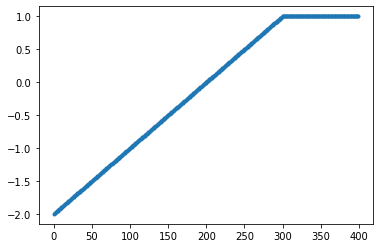

In [12]:
# Let's plot the saturated function. 
class ConventionalNet(Sequential):
    def __init__(self):
        super().__init__(layers=[Linear(w=-w, has_unit_bias=True, has_relu_activation=True),
                                 Linear(w=np.array([[-1.0]]), has_unit_bias=True)])
conventional_net = ConventionalNet()
y = [conventional_net.forward(np.expand_dims(x, 1)).squeeze() for x in X]
plt.scatter(range(len(y)), y, marker='.')
plt.show()

## Pattern Computation for the ReLU case. 

We need to recompute the patterns for the ReLU case. 

In [13]:
class PatternAttributionNet(Sequential):
    def __init__(self):
        super().__init__(layers=[PatternAttribution(w=-w, has_unit_bias=True, has_relu_activation=True),
                                 PatternAttribution(w=np.array([[-1.0]]), has_unit_bias=True)])
pattern_attribution_net = PatternAttributionNet() # Two-layer feed-forward net with PatternAttribution layers. 
[_p1, _p2] = pattern_attribution_net.set_patterns(X) # Patterns now set in pattern_attribution 

print('Pattern Layer One:')
print(_p1)
print('\nPattern Layer Two:')
print(_p2)

Pattern Layer One:
[[-1.00329617]
 [-0.00329617]
 [ 0.        ]]

Pattern Layer Two:
[[-1.]
 [ 0.]]


## 5) Stress Testing Integrated Gradients and PatternAttribution. 

Let us now test Integrated Gradients and PatternAttribution with noisy inputs to the saturated function.

Implementing PatternAttribution is straight forward. We simply collect the gradients with the patterns in place.

### PatternAttribution

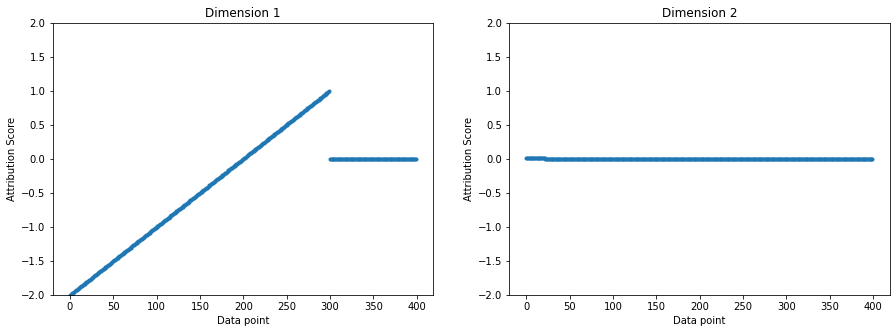

In [14]:
saliencies_pattern_attribution = []
for x in X:
    x = np.expand_dims(x, 1)
    pred = pattern_attribution_net.forward(x) # patterns are set above
    grad = pattern_attribution_net.backward(pred)
    saliencies_pattern_attribution.append(grad)
saliencies_pattern_attribution = np.array(saliencies_pattern_attribution)

def show_saliencies(saliencies, 
                    title_dim_one='Dimension 1', 
                    title_dim_two='Dimension 2'):
    plt.figure(figsize=(15,5))
    plt.subplot(121, label='dim1')
    plt.scatter(range(len(saliencies)), saliencies[:,0], marker='.')
    plt.ylim(-2, 2)
    plt.xlabel('Data point')
    plt.ylabel('Attribution Score')
    plt.title(title_dim_one)
    plt.subplot(122, label='two')
    plt.scatter(range(len(saliencies)), saliencies[:,1], marker='.')
    plt.title(title_dim_two)
    plt.xlabel('Data point')
    plt.ylabel('Attribution Score')
    plt.ylim(-2, 2)
    plt.show()
    
show_saliencies(saliencies_pattern_attribution)

#### As can be seen, PatternAttribution sucessfully bypasses the noise in dimension 2 but *it starves at the plateau*! 

### Integrated Gradients

For Integrated Gradients, we need to implement the path method. 
We do this in a way such that the later implementation of Pattern-Guided Integrated Gradients is facilitated. 

In [15]:
def walk_the_line(x, b, model, steps=100, is_pattern_guided=False):
    """
    Walks a straight path from the baseline (b) to the point of interest (x), collects and averages gradients.

    Args:
        x: The input.
        b: The baseline from where to start the straight path to x.
        model: The model to explain.
        is_pattern_guided: Whether or not this is a call to pattern-guided integrated gradients.

    Returns: (Pattern-Guided) Integrated gradients.
    """
    grads = []
    
    def switch(y):
        if is_pattern_guided:
            return y # if pattern-guided, propagate back y instead of 1.0, see Kindermans et al. (2017) 
        else: 
            return 1.0

    for step in range(steps):  # Walk the line.
        alpha = (step + 1) / steps  # Step size.
        x_ = b + alpha * (x - b)  # Input <step> along the straight path from b to x.
        output = model.forward(x_)  
        grad = model.backward(switch(output))
        grads.append(grad)
        
    grads = np.asarray(grads).squeeze()
    grads = np.expand_dims(np.array([(np.sum(grads[:, 0]) / steps), (np.sum(grads[:, 1]) / steps)]), axis=1)
    saliencies = (x - b) * grads  # Multiply with difference vector.

    return grads, saliencies

In [16]:
base_line = np.array([[0], [0]])  # yields zero
saliencies_integrated_gradients = []
for idx, x in enumerate(X):
    grads, saliencies = walk_the_line(x=np.expand_dims(x, 1), model=conventional_net, b=base_line)
    saliencies_integrated_gradients.append(saliencies)
saliencies_integrated_gradients = np.array(saliencies_integrated_gradients).reshape(len(X), 2)

Let us implement a quick sanity check. Integrated gradients meets the property of completeness, that is $\sum_{i}^{D}\phi_{i}^{IG}(f,x) = f(x)$; the sum of saliency scores should amount to the output of the model (within the bounds of numerical imprecisions). 

In [17]:
random_indices = [0, 101, 202, 303, -1]
for idx in random_indices:
    x = X[idx]
    pred = conventional_net.forward(x)
    sal_sum = np.sum(saliencies_integrated_gradients[idx])
    print(f'pred: {pred} sum_sal: {sal_sum}')

pred: [[-2.]] sum_sal: -2.0
pred: [[-0.99]] sum_sal: -0.9899999999999991
pred: [[0.02]] sum_sal: 0.020000000000001794
pred: [[1.]] sum_sal: 0.9991000000000028
pred: [[1.]] sum_sal: 0.995000000000002


Good enough. Let us now inspect the attribution scores.  

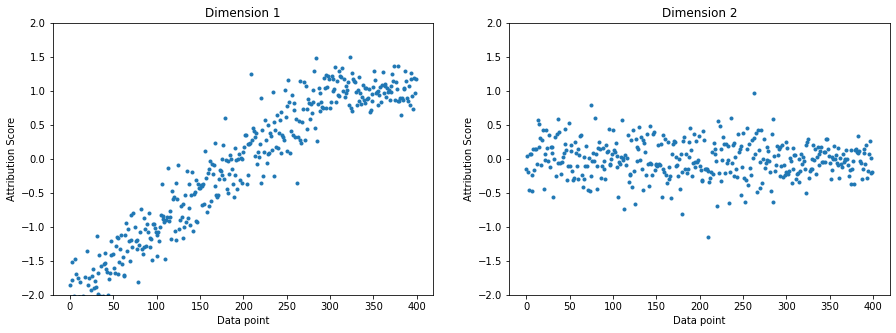

In [18]:
show_saliencies(saliencies_integrated_gradients)

#### As can be seen, Integrated Gradients does not starve at the plateau but it attributes importance to the noise in dimension 2!



## Pattern-Guided Integrated Gradients

In response, we propose Pattern-Guided Integrated Gradients (or Integrated PatternAttribution, if you will). 

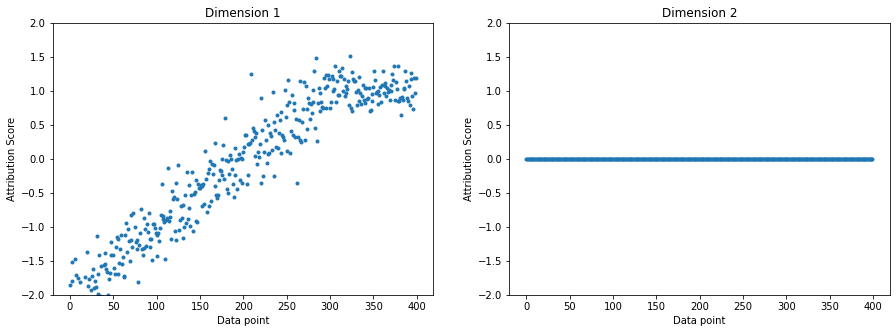

In [19]:
saliencies_pattern_guided_integrated_gradients = []
for idx, x in enumerate(X):
    grads, saliencies = walk_the_line(x=np.expand_dims(x, 1), model=pattern_attribution_net, b=base_line)
    saliencies_pattern_guided_integrated_gradients.append(saliencies)
saliencies_pattern_guided_integrated_gradients = np.array(saliencies_pattern_guided_integrated_gradients).reshape(len(X), 2)
show_saliencies(saliencies_pattern_guided_integrated_gradients)

#### As can be seen, Pattern-Guided Integrated Gradients does not(!) starve at the plateau and successfully bypasses the noise!

Finally, let us save the results for the paper. 

In [20]:
%%capture
base_dir = 'csvs'
savetxt(os.path.join(base_dir, 'z.csv'), list(zip(list(range(len(z.T))), z.T)), delimiter=',')
savetxt(os.path.join(base_dir, 'y.csv'), list(zip(list(range(len(y))), y)), delimiter=',')
savetxt(os.path.join(base_dir, 'signal.csv'), signal, delimiter=',')
savetxt(os.path.join(base_dir, 'distractor.csv'), distractor, delimiter=',')
savetxt(os.path.join(base_dir, 'X.csv'), X, delimiter=',')

SIGNAL_DIM = 0
DISTRACTOR_DIM = 1
savetxt(os.path.join(base_dir, 'IG_signal.csv'), list(zip(list(range(len(saliencies_integrated_gradients))), 
                                                          saliencies_integrated_gradients[:, SIGNAL_DIM])), delimiter=',')

savetxt(os.path.join(base_dir, 'IG_distractor.csv'), list(zip(list(range(len(saliencies_integrated_gradients))), 
                                                          saliencies_integrated_gradients[:, DISTRACTOR_DIM])), delimiter=',')

savetxt(os.path.join(base_dir, 'PA_signal.csv'), list(zip(list(range(len(saliencies_pattern_attribution))), 
                                                          saliencies_pattern_attribution[:, SIGNAL_DIM])), delimiter=',')

savetxt(os.path.join(base_dir, 'PA_distractor.csv'), list(zip(list(range(len(saliencies_pattern_attribution))), 
                                                          saliencies_pattern_attribution[:, DISTRACTOR_DIM])), delimiter=',')

savetxt(os.path.join(base_dir, 'PGIG_signal.csv'), list(zip(list(range(len(saliencies_pattern_guided_integrated_gradients))), 
                                                          saliencies_pattern_guided_integrated_gradients[:, SIGNAL_DIM])), delimiter=',')

savetxt(os.path.join(base_dir, 'PGIG_distractor.csv'), list(zip(list(range(len(saliencies_pattern_guided_integrated_gradients))), 
                                                          saliencies_pattern_guided_integrated_gradients[:, DISTRACTOR_DIM])), delimiter=',')